# Thema 3 werkcollege 3: Transformers
We gaan hier door met de 'videogames review' dataset van vorige week. Vorige keer zagen we dat we met diverse Recurrent Neural Netwerken eigenlijk steeds niet hoger kwamen dan een validated accuracy van net onder de 91%. Transformers bieden een alternatieve en modernere aanpak, welke we hier verder gaan verkennen. 

Om te beginnen lezen we hier de dataset weer in; tokenizen we deze; voegen we padding toe. Aangezien we deze stappen nu wel begrijpen doen we het nu met behulp van een <u>vectorization layer</u>. Dit vraagt wel wat voorbereiding aangezien we hiervoor onze train en test dataframes om moeten zetten naar een dataset object. Dit heeft onder andere als voordeel dat we niet alles in 1 keer in het geheugen hoeven te laden. Nu is dit hier nog niet zo van belang, maar bij grotere datasets wel. 

Bestudeer onderstaande code, voer deze uit, en probeer te begrijpen wat het doet. (zie ook:  https://www.tensorflow.org/guide/data) en https://medium.com/analytics-vidhya/getting-started-with-tensorflow-input-pipeline-aa0f31eea74a

Max 15 min

In [1]:
import pandas as pd
df= pd.read_excel('gamereviews.xlsx')
text=df['reviewText'].astype('str')
sentiment=df['sentiment'].astype('int')
print(text.head())
print(sentiment.head())
print(sentiment.sum())

0    If you're looking for immersive gameplay, good...
1    The zippers on this bag are terrible. I ordere...
2    If you need a good intro to Wii games, this is...
3    This game has brought back so many great memor...
4    True Crime: Streets of LA was my first experie...
Name: reviewText, dtype: object
0    0
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int32
50000


In [2]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_targets, test_targets = train_test_split(
        text, sentiment,
        test_size=0.2,
        random_state=1,
        shuffle = True,
        stratify=sentiment
    )

In [3]:
import tensorflow as tf

#omzetten naar tensorflow dataobject met een batch_size van 64
#NB meer infor voor de docent https://www.geeksforgeeks.org/difference-between-dataset-from_tensors-and-dataset-from_tensor_slices/
train_text = tf.data.Dataset.from_tensor_slices(tf.cast(train_features.values, tf.string)).batch(64) #default batch is 32
train_cat = tf.data.Dataset.from_tensor_slices(tf.cast(train_targets.values, tf.int64)).batch(64)
test_text = tf.data.Dataset.from_tensor_slices(tf.cast(test_features.values, tf.string)).batch(64)
test_cat = tf.data.Dataset.from_tensor_slices(tf.cast(test_targets.values, tf.int64)).batch(64)

for each in train_text.take(3): #toon de 1e 3 reviews
  print(each)

tf.Tensor(
[b'It\'s perhaps worthwhile getting this if you buy it packaged with the remote.  But without the remote, it\'s not worth the $10.  Most of the minigames aren\'t all that fun, with the "Duck Hunt" game being the best, in my opinion, but that\'s too short to really be enjoyable for much more than a couple of plays.  We had significant trouble getting the fishing and billiards games to work (perhaps where we have the sensor makes it difficult to register, but it\'s worked very well for other games, like the shooter, so who knows?).  I\'m not losing any sleep over the extra $10 I paid to get the game, but you really won\'t get much play time out of it at all, and I agree with some other reviews I\'ve seen that say it\'s not worth the extra $10 - just buy the remote on its own.'
 b"If you have a windows 7 computer do not buy this product. The product will not download and EA is not attempting to fix the problem anytime soon. This product works well with Windows XP, and I'm not s

In [4]:
#samenvoegen naar 1 train en test dataset
train_ds = tf.data.Dataset.zip((train_text,train_cat))
test_ds = tf.data.Dataset.zip((test_text,test_cat))

for each in train_ds.take(1): #toon de 1e batch
  print(each)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'It\'s perhaps worthwhile getting this if you buy it packaged with the remote.  But without the remote, it\'s not worth the $10.  Most of the minigames aren\'t all that fun, with the "Duck Hunt" game being the best, in my opinion, but that\'s too short to really be enjoyable for much more than a couple of plays.  We had significant trouble getting the fishing and billiards games to work (perhaps where we have the sensor makes it difficult to register, but it\'s worked very well for other games, like the shooter, so who knows?).  I\'m not losing any sleep over the extra $10 I paid to get the game, but you really won\'t get much play time out of it at all, and I agree with some other reviews I\'ve seen that say it\'s not worth the extra $10 - just buy the remote on its own.',
       b"If you have a windows 7 computer do not buy this product. The product will not download and EA is not attempting to fix the problem anytime soon. This 

In [5]:
#Vectorize de train en de test dataset.
from tensorflow.keras import layers
vocab_size = 10000  # voor de vergelijkbaarheid ook deze les maar 10000 woorden
maxlen = 50  # we beperken ons net als vorige les nog steeds tot de 1e 50 woorden

text_vectorization = layers.TextVectorization( #define de text vercotorisation layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=maxlen,
)
text_vectorization.adapt(train_text)
# text_vectorization.adapt:
# If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted,
# it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary'
# from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer;
# if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to
# create the vocabulary.

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
#pas de text_vectorisation op de train dataset (4 par jobs per keer,  x is features, y is sentiment)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for each in int_train_ds.take(1): #toon de 1e batch
  print(each)

# Bovenstaande code is een alternatief voor grofweg onderstaande (niet 1-op-1 uitwisselbaar)
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# maxlen=100

# tokenizer = Tokenizer(num_words=maxtokens) #geef het maximale aantal woorden.
# tokenizer.fit_on_texts(text) #bouw de index
# sequences = tokenizer.texts_to_sequences(text)
# padded_sequence = pad_sequences(sequences, maxlen=maxlen)

(<tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[  24,  942, 3221, ...,   25,  852,   15],
       [  27,   10,   20, ...,    0,    0,    0],
       [  22,  531,    0, ...,    0,    0,    0],
       ...,
       [  50,    7,   65, ...,  578,   19,   12],
       [  90,    6,    2, ...,    0,    0,    0],
       [ 187,   12,   15, ...,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1],
      dtype=int64)>)


We gaan nu een 1e transformer introduceren. Deze komt uit de [github van cholet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb) en is gebasseerd op het het paper [attention is al you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Wederom de vraag om de code te bestuderen (10 min). 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):                              # Our transformer encoder layer inherits from keras.layers.Layer
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):   # the constructor of our encoder layer
        super().__init__(**kwargs)                                   # calls the constructor of the parent class (keras.layers.Layer)

        # Store a whole bunch settings and initialise the building blocks for our encoder layer
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention building block
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense building block
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        # Layer normalisation building block, 1 and 2 are used to normalise the output of the attention and dense blocks respectively
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Here we actually build the encoder layer

        # If we define a mask for attention, we need to perform some preprocessing on it
        if mask is not None:
            mask = mask[:, tf.newaxis, :] #padding mask (negeer alle paffing) voeg een dimensie toe. Transformer verwacht 3D of meer. Embedding layer genereerd 2d layer

        # Define the attention part of the encoder
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        # Apply layer normalisation to the attention output
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply the dense part of the encoder
        proj_output = self.dense_proj(proj_input)
        # Apply layer normalisation to the dense output, and return the encoder
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        # Return all the configuration settings for this layer

        # Get the configuration settings from the parent class
        config = super().get_config()
        # Add the config settings of our own layer
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Definieer nu het benodigde model bestaande uit een Embedding layer; een transformer, 
een glolbalmaxpooling-layer en een dropout van 0.5. Gebruik 8 heads en een dense_dim van 32

Tip: zoek de juiste code op in de cholet link hierboven en pas deze aan.

In [7]:
# defineer het benodigde model (max 10m)

num_heads = 8
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, maxlen)(inputs) #geef inputs mee aan de embedding layer en stop het resultaat in x
x = TransformerEncoder(maxlen, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) #terug naar een enkele vector
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs) #model bestaat uit combi van in en output
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          500000    
                                                                 
 transformer_encoder (Transf  (None, None, 50)         84732     
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51    

We gaan nu het model fitten. Soms zie je dat je laatste epoch niet altijd het beste resultaat heeft. Daaron gaan we gebruik maken van 'callbacks' om de beste oplossing terug te kunnen halen. Zoek uit hoe je dit gebruikt en pas dit toe. Let op onze eigen geschreven klasse "TransformerEncoder" zullen we deze dmv de "custom_objects" parameter toe moeten voegen)  

In [8]:
# compile en fit het model en maak gebruik van collbacks om de beste oplossing terug te kunnen halen.
# NB: epochs=5 validation_split=0.5
# ca 15 min

# Sommige versies van keras lopen op `ModelCheckpoint` vast. Gebruik dan `.h5` als extensie ipv `.keras`
callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder.keras",save_best_only=True)]

history=model.fit(int_train_ds, validation_data=int_test_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
1250/1250 [==============================] - 29s 20ms/step - loss: 0.3853 - accuracy: 0.8238 - val_loss: 0.3073 - val_accuracy: 0.8712
Epoch 2/10
1250/1250 [==============================] - 23s 19ms/step - loss: 0.2929 - accuracy: 0.8780 - val_loss: 0.2979 - val_accuracy: 0.8759
Epoch 3/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2761 - accuracy: 0.8871 - val_loss: 0.2933 - val_accuracy: 0.8770
Epoch 4/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2670 - accuracy: 0.8920 - val_loss: 0.2934 - val_accuracy: 0.8771
Epoch 5/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2589 - accuracy: 0.8953 - val_loss: 0.2949 - val_accuracy: 0.8771
Epoch 6/10
1250/1250 [==============================] - 23s 19ms/step - loss: 0.2524 - accuracy: 0.8984 - val_loss: 0.2900 - val_accuracy: 0.8795
Epoch 7/10
1250/1250 [==============================] - 23s 19ms/step - loss: 0.2449 - accuracy: 0.9019 - val_loss: 0.2888 -

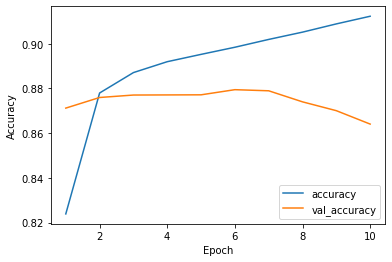

In [9]:
#plot de accuracy, de validated accuracy (gegeven)
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Wat zie je hier? Doet dit tansformermodel het beter dan de modellen uit de vorige les. Leg onderstaande afbeelding nog eens naast de transformer code. Waar zitten de verschillen? 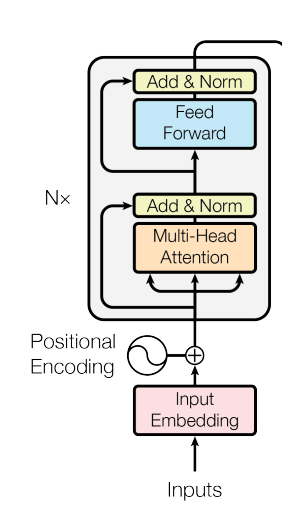

[Antwoord] Ons 1e transformermodel lijkt het zelfs wat slechter te doen dan de meeste RNN oplossingen van vorige week (al lijkt er nog wel een klein beetje stijing in te zitten door meer epochs te gaan trainen).  Dit zou kunnen komen doordat onze embeddings nog steeds geen rekening houden met de positie van een woord in de zin (zie ook de afbeeelding). 


We gaan onze transformer uitbreiden met een positional embedding layer. Deze komt wederom uit de [github van choler](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb) en is gebasseerd op het het paper [attention is al you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).  


Bestudeer onderstaande code; pas het model aan zodat ipv de reguliere embeddding gebruik wordt gemaakt van onze nieuwe positional embedding en run het opnieuw. 

NB:Voor de vergelijkbaarheid met vorige keer gebruiken we wederom een embedding dimensie (output_dim) van 100

In [10]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [1]:
#geef hier het aangepast model en run het (epochs wederom 5)
embed_dim = 100 #idem als vorige les

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)#overfit bij 0.8
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [keras.callbacks.ModelCheckpoint("transformer.keras", save_best_only=True)]
history=model.fit(int_train_ds, validation_data=int_test_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("transformer.keras",custom_objects={"TransformerEncoder": TransformerEncoder,"PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

NameError: name 'keras' is not defined

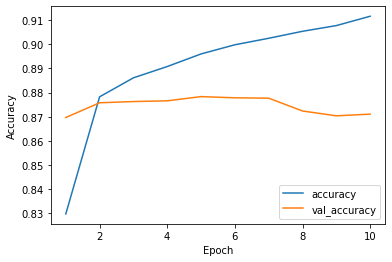

In [12]:
#plot de accuracy, de validated accuracy
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Bekijk het resultaat en probeer te verklaren waarom dit wel of niet werkt

[docent] eventueel hint geven naar vuistregel eind vorige les

Helaas heeft dit nog steeds <u>niet</u> het effect wat we zouden verwachten. Belangrijkst reden hiervoor is dat transformer erg veel data nodig hebben om echt hun kracht te kunnen laten zien. Dit komt doordat transformers een vrij complexe architectuur met veel meer parameters hebben, waardoor ze veel meer gegevens en epochs nodig hebben om effectief te worden getraind.

Bij heel kleine datasets is het zelfs zo dat een bag-of-words benadering zoals met alleen een embedding het vaak beter doen dan zowel transformers als RNN's. De belangrijkste oorzaak zit hem in <u>de hoeveelheid samples t.o.v. de gemiddelde sample lengte </u> (hier afgekapt op 50).  Een richtlijn uit cholet p349 is dat als het <u> aantal samples gedeeld door de gemiddelde sample length < 1500</u> een bag-of-words methode beter werkt dan een transformer of een RNN. In deze casus trainen we met 90.000 reviews en 50 woorden = 1800 waardoor we nog maar heel beperkt boven deze vuistregel zitten.
    
In dit geval heeft het dus niet zoveel zin om met deze beperkte dataset verder te gaan met een sentiment-analyse op basis van transformers. Bij een grotere dataset zou dit zeker wel zinvol zijn!!

# Sequence 2 sequence
We gaan verder met transformers en deze toepassen in de context waarvoor je ooit zijn bedacht, namelijk vertalen. Groot verschil me de voorgaande situatie is dat we niet alleen een encoder gebruiker maar ook een decoder

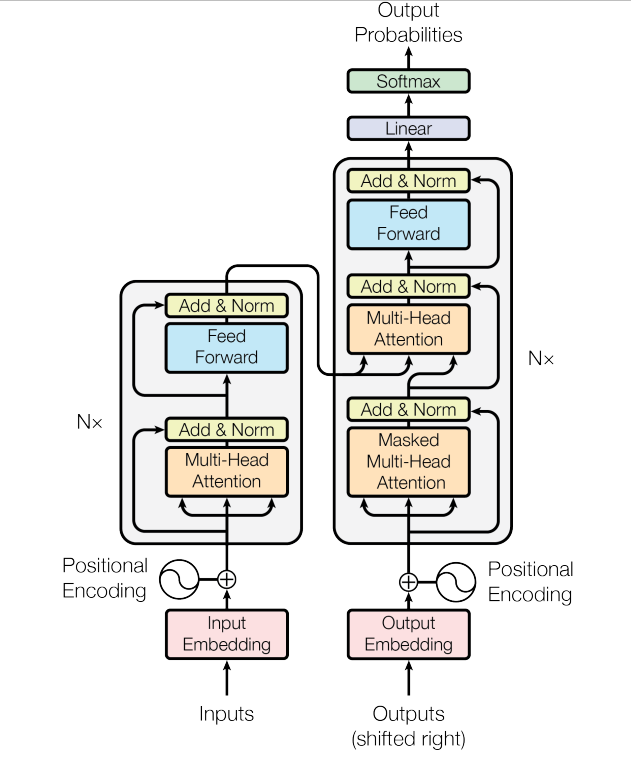

Op de elo vind je een dataset (nedeng.txt) afkomsting van https://tatoeba.org/ waarin met daarin paren van nederlandse en engelse zinnen.

In [13]:
# open de gegeven dataset nedeng.txt en zorg ervoor dat je een list eng en een list nl aanmaakt
# met de met bij elkaar horende zinnen op dezelfde index
# zet om de nederlandse vertaling steed [start] en [end]
# append beide in de list 'text_pairs'

text_file = "nedeng.txt"
with open(text_file, encoding='utf8') as f:
    lines = f.read().split("\n")[:-1] #laatste veelal lege regel lezen we niet.
text_pairs = []
for line in lines:
    english, nl, drop = line.split("\t") #drop is om extra 3e kolom af te vangen specifiek voor nl dataset
    nl = "[start] " + nl + " [end]"
    text_pairs.append((english, nl))

text_pairs

[('Go.', '[start] Lopen! [end]'),
 ('Go.', '[start] Vooruit. [end]'),
 ('Hi.', '[start] Hoi. [end]'),
 ('Hi.', '[start] Hé! [end]'),
 ('Hi.', '[start] Hai! [end]'),
 ('Run!', '[start] Ren! [end]'),
 ('Run!', '[start] Vlucht. [end]'),
 ('Run.', '[start] Ren! [end]'),
 ('Run.', '[start] Vlucht. [end]'),
 ('Who?', '[start] Wie? [end]'),
 ('Wow!', "[start] Da's niet gek! [end]"),
 ('Duck!', '[start] Eend! [end]'),
 ('Fire!', '[start] Vuur! [end]'),
 ('Fire!', '[start] Brand! [end]'),
 ('Help!', '[start] Help! [end]'),
 ('Jump.', '[start] Spring. [end]'),
 ('Stop!', '[start] Stop! [end]'),
 ('Stop!', '[start] Hou op! [end]'),
 ('Stop!', '[start] Hou daarmee op! [end]'),
 ('Stop!', '[start] Geen beweging! [end]'),
 ('Stop!', '[start] Halt! [end]'),
 ('Stop!', '[start] Hou op. [end]'),
 ('Wait.', '[start] Wacht. [end]'),
 ('Hello!', '[start] Hallo. [end]'),
 ('Hello!', '[start] Goedemorgen! [end]'),
 ('Hello!', '[start] Hoi. [end]'),
 ('Hello.', '[start] Hallo. [end]'),
 ('Hello.', '[start] H

## Dataprep
De eerste stap die we nu gaan doen is een train_pais en test_pairs list aanmaken 

In [14]:
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(text_pairs,test_size=0.2,random_state=16, shuffle = True)

test_pairs[0:5] #1e 5 test zinnen tonen

# Cholet way
#import random
# random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 2 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples:]

[("They won't believe us.", '[start] Ze zullen ons niet geloven. [end]'),
 ('He has poor eyesight.', '[start] Hij ziet slecht. [end]'),
 ('There is a church near my house.',
  '[start] Er staat een kerk naast mijn huis. [end]'),
 ('You work too much.', '[start] U werkt te veel. [end]'),
 ("You're gonna love this.", '[start] Je gaat dit geweldig vinden. [end]')]

Hieronder volgt een stuk voorbeeldcode (bijna 1-op-1 overgenomen van: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb) 

De onderstaande stappen :
- schonen de train en test datasets op en vectorizen (tokenize en sequence + padding) de zinnen
- converteren de train en test list naar een dataset object met daarin een eng input, een nl input en een target output

Bestudeer onderstaande code (10 min)

In [15]:
#schoon de zinnen op (lowercase, interpunctie etc.) en vectorize de zinnen [gegeven]

import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation # vewijder intterpunctie
strip_chars = strip_chars.replace("[", "") #zorgt ervoor dat de [ en ] behouden blijven
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization( #English layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(#Dutch Layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, standardize=custom_standardization
    #Generate Dutch sentences that have one extra token, since we need to offset
    #the sentence by one step during training
)

train_english_texts = [pair[0] for pair in train_pairs]
train_nl_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_nl_texts)

In [16]:
# omzetten dataset objecten
# extra info(https://huggingface.co/docs/datasets/v1.0.1/exploring.html)

batch_size = 64

def format_dataset(eng, nl):
    eng = source_vectorization(eng)
    nl = target_vectorization(nl)
    return ({
        "english": eng,
        "nl": nl[:, :-1], #the input sentence doesn't include the last token, to keep input and target the same length
    }, nl[:, 1:]) #the target sentence is one step ahead. Both are still the samen length (20 words)

def make_dataset(pairs):
    eng_texts, nl_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nl_texts = list(nl_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, nl_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset #.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [17]:
#check of alles dezelfde shape heeft
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['nl'].shape: {inputs['nl'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['nl'].shape: (64, 20)
targets.shape: (64, 20)


## De transformer decoder
Nu we de dataprep hebben afgerond kunnen we verder gaan met onze transformerarchitectuur. De encoder en position embbedding hebben we al eerder gedefinieerd dus hoeven we niet opnieuw te doen. Nieuw is de transformer decoder welke we basseren op het attention is all you need paper definieren (zie een stukje hierboven). Bestudeer onderstaande code en vergelijk deze met de afbeelding hierboven. Komt deze overeen? 

[DOCENT] 10 min
NB: Een oplettende student ziet misschien dat we maar 1 transformerblock hebben ipv Nx. In het originele artikel wordt gesproken over 6 keer. Ik heb dit even voor de grap greprobeerd, maar ik zou maar een slaapzak meenemen

In [18]:
#define de TransformerDecoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = tf.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Nu we onze decoder ook gedefinieerd hebben, kunnnen we ons model opstellen. We voegen daarom nu ook een decoder blok toe aan ons model, compilen dit, en fitten dit (5 epochs). We stellen de embed_dim en dense-dim 256 en 2048. Het aantal heads houden we op 8.

Tip: check eventueel de cholet voorbeeldcode om te kijken hoe je dit kunt doen https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

Ca 45 minuten

In [19]:
#maak een seq2seq model
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
#encode de source sentenct

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="nl")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
#Encode the target sentence and combine it with the encoded source sentence
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
#predict a word for each output position
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [20]:
#hierna fitten we ons model. Ivm de tijd beperken we ons tot 5 epochs
#Koffie!!
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
920/920 [==============================] - 86s 90ms/step - loss: 1.4777 - accuracy: 0.4751 - val_loss: 1.1808 - val_accuracy: 0.5644
Epoch 2/5
920/920 [==============================] - 82s 89ms/step - loss: 1.1510 - accuracy: 0.5839 - val_loss: 1.0495 - val_accuracy: 0.6077
Epoch 3/5
920/920 [==============================] - 82s 89ms/step - loss: 1.0203 - accuracy: 0.6240 - val_loss: 0.9535 - val_accuracy: 0.6413
Epoch 4/5
920/920 [==============================] - 86s 94ms/step - loss: 0.9412 - accuracy: 0.6497 - val_loss: 0.9199 - val_accuracy: 0.6554
Epoch 5/5
920/920 [==============================] - 88s 96ms/step - loss: 0.9012 - accuracy: 0.6668 - val_loss: 0.9144 - val_accuracy: 0.6608


In [21]:
#testcode
import numpy as np
import random
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        #sample next token
        sampled_token = nl_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        #convert the next token to a string and append it to the generated sequence
        if sampled_token == "[end]":
            break #exit condition
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom doesn't eat Italian food very often.
[start] tom eet niet veel eten [end]
-
The clock struck half past 12.
[start] de klok hield het voor het ontbijt [end]
-
Tom stood behind me.
[start] tom zat achter mij [end]
-
I'll miss you when you're gone.
[start] ik zal u komen wanneer je weg bent [end]
-
You forgot to tell me to buy bread.
[start] je bent vergeten mij te vertellen dat je brood [end]
-
Tea was introduced from China.
[start] thee was gemaakt van australië [end]
-
Are you still cold?
[start] ben je nog steeds koud [end]
-
Look out!
[start] kijk uit [end]
-
Tom won't tell us what he knows.
[start] tom zal ons niet vertellen wat hij weet [end]
-
I want kids, but my husband doesn't.
[start] ik wil kinderen maar mijn man niet niet zijn [end]
-
Who designed the White House?
[start] wie heeft het rood je gebruiken [end]
-
I want an apple.
[start] ik wil een appel [end]
-
These garments are made of 100 percent wool.
[start] deze dit is gemaakt van een beetje pijn gemaakt [end]
-
I 

Wat zien we nu? Hoe goed werkt dit? Hoe zou je de resultaten nog kunnen verbeteren? 

[antwoord] We zien nu zelfs na 10 epochs al best wel redelijke zinnen ontstaan. In de praktijk gebruik je vaak veel meer epochs 100+. Let alleen wel op overfitten. Transformers hebben daar best wel de neiging toe, en op zich is dit helemaal niet zo erg, maar probeer het wel zoveel mogelijk binnen de perken te houden. 

In [22]:
#als showcase ook nog even wat meer getraind evt aan de studenten laten zien
transformer.fit(train_ds, epochs=100, validation_data=test_ds)
#nog even testen
import numpy as np
import random
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = nl_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

Epoch 1/100
920/920 [==============================] - 80s 87ms/step - loss: 0.7589 - accuracy: 0.7343 - val_loss: 0.8632 - val_accuracy: 0.6957
Epoch 2/100
920/920 [==============================] - 80s 87ms/step - loss: 0.7459 - accuracy: 0.7405 - val_loss: 0.8647 - val_accuracy: 0.6966
Epoch 3/100
920/920 [==============================] - 84s 92ms/step - loss: 0.7346 - accuracy: 0.7468 - val_loss: 0.8643 - val_accuracy: 0.6988
Epoch 4/100
920/920 [==============================] - 81s 88ms/step - loss: 0.7235 - accuracy: 0.7524 - val_loss: 0.8657 - val_accuracy: 0.7008
Epoch 5/100
920/920 [==============================] - 80s 87ms/step - loss: 0.7120 - accuracy: 0.7579 - val_loss: 0.8676 - val_accuracy: 0.7046
Epoch 6/100
920/920 [==============================] - 80s 87ms/step - loss: 0.7014 - accuracy: 0.7626 - val_loss: 0.8643 - val_accuracy: 0.7063
Epoch 7/100
920/920 [==============================] - 80s 87ms/step - loss: 0.6906 - accuracy: 0.7681 - val_loss: 0.8670 - val_ac

In [22]:
transformer.save("myfirsttransformer")

INFO:tensorflow:Assets written to: myfirsttransformer\assets


INFO:tensorflow:Assets written to: myfirsttransformer\assets
